# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL, GRASIM.NS, SBIN.NS
STOCK = 'SBIN.NS'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [5]:
init_df.tail(12)

,open,high,low,close,adjclose,volume,ticker
2023-07-14,586.750000,591.299988,580.700012,584.400024,584.400024,12190152.0,SBIN.NS
2023-07-17,587.000000,602.849976,584.200012,601.099976,601.099976,19378986.0,SBIN.NS
2023-07-18,603.049988,604.049988,588.750000,592.349976,592.349976,25757209.0,SBIN.NS
2023-07-19,594.650024,602.400024,592.000000,601.450012,601.450012,17556585.0,SBIN.NS
2023-07-20,601.400024,610.799988,598.750000,610.049988,610.049988,34038351.0,SBIN.NS
2023-07-21,610.000000,619.500000,609.000000,615.099976,615.099976,21040281.0,SBIN.NS
2023-07-24,615.049988,621.900024,614.299988,617.650024,617.650024,11756364.0,SBIN.NS
2023-07-25,621.799988,621.799988,604.200012,609.599976,609.599976,18503305.0,SBIN.NS
2023-07-26,612.000000,616.349976,609.150024,615.150024,615.150024,9999125.0,SBIN.NS
2023-07-27,616.400024,621.250000,613.099976,616.549988,616.549988,17444742.0,SBIN.NS


In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [7]:
init_df

,close,date
2020-07-23,198.250000,2020-07-23
2020-07-24,191.949997,2020-07-24
2020-07-27,187.149994,2020-07-27
2020-07-28,189.449997,2020-07-28
2020-07-29,191.199997,2020-07-29
...,...,...
2023-07-25,609.599976,2023-07-25
2023-07-26,615.150024,2023-07-26
2023-07-27,616.549988,2023-07-27
2023-07-28,616.049988,2023-07-28


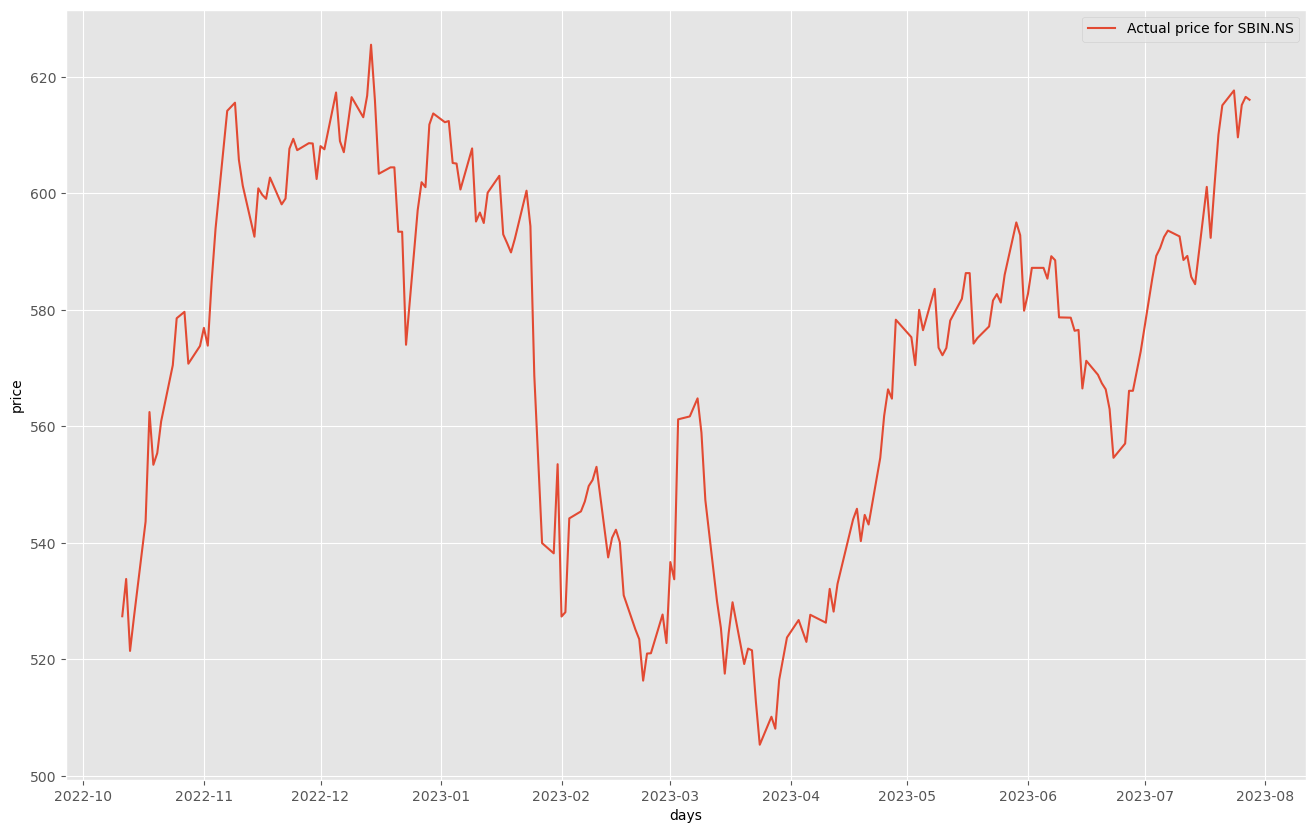

In [8]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [9]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [10]:
init_df

,close,date,scaled_close
2020-07-23,198.250000,2020-07-23,0.048759
2020-07-24,191.949997,2020-07-24,0.034732
2020-07-27,187.149994,2020-07-27,0.024045
2020-07-28,189.449997,2020-07-28,0.029166
2020-07-29,191.199997,2020-07-29,0.033062
...,...,...,...
2023-07-25,609.599976,2023-07-25,0.964600
2023-07-26,615.150024,2023-07-26,0.976957
2023-07-27,616.549988,2023-07-27,0.980073
2023-07-28,616.049988,2023-07-28,0.978960


In [11]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [12]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2020-07-23  198.250000 2020-07-23      0.048759  0.029166
 2020-07-24  191.949997 2020-07-24      0.034732  0.033062
 2020-07-27  187.149994 2020-07-27      0.024045  0.022710
 2020-07-28  189.449997 2020-07-28      0.029166  0.033619
 2020-07-29  191.199997 2020-07-29      0.033062  0.035400
 ...                ...        ...           ...       ...
 2023-07-19  601.450012 2023-07-19      0.946454  0.982523
 2023-07-20  610.049988 2023-07-20      0.965602  0.964600
 2023-07-21  615.099976 2023-07-21      0.976845  0.976957
 2023-07-24  617.650024 2023-07-24      0.982523  0.980073
 2023-07-25  609.599976 2023-07-25      0.964600  0.978960
 
 [748 rows x 4 columns],
 array([[0.94567513],
        [0.9261939 ],
        [0.94645447],
        [0.9656017 ],
        [0.9768451 ],
        [0.9825226 ],
        [0.9645997 ],
        [0.98007345],
        [0.9789602 ],
        [       nan]], dtype=float32),
 array([[[0.0487587536326042

In [13]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [14]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
93/93 [==============================] - 6s 7ms/step - loss: 0.0192
Epoch 2/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0049
Epoch 3/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0043
Epoch 4/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0038
Epoch 5/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 6/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 7/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0033
Epoch 8/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0034
Epoch 9/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 10/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0024
Epoch 11/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0028
Epoch 12/80
93/93 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 13/80
93/93 [==============================

93/93 [==============================] - 1s 8ms/step - loss: 0.0035
Epoch 8/80
93/93 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 9/80
93/93 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 10/80
93/93 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 11/80
93/93 [==============================] - 1s 9ms/step - loss: 0.0027
Epoch 12/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0028
Epoch 13/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0029
Epoch 14/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0023
Epoch 15/80
93/93 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 16/80
93/93 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 17/80
93/93 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 18/80
93/93 [==============================] - 1s 9ms/step - loss: 0.0020
Epoch 19/80
93/93 [==============================] 

93/93 [==============================] - 1s 10ms/step - loss: 0.0030
Epoch 14/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0031
Epoch 15/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0028
Epoch 16/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 17/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0027
Epoch 18/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0024
Epoch 19/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 20/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0023
Epoch 21/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 22/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0028
Epoch 23/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0022
Epoch 24/80
93/93 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 25/80
93/93 [=====================

In [15]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

SBIN.NS prediction for upcoming 3 days (nan$, nan$, nan$)


In [16]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 4ms/step


ValueError: Length of values (751) does not match length of index (752)

In [ ]:
copy_df

In [ ]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()